## Calculates the core decomposition of a graph using the `Core` Action in the `NETWORK` Actionset
------------------------------------------------------------------------------------------------------------------------------
This Jupyter notebook provides an example of building a graph of English words to demonstrate the use of `core` action in the `network` action set. This example idea was taken from Vladimir Batagelj, Matjaz Zaversnik's paper titled "An O(m) Algorithm for Cores Decomposition of Networks." 

We used a Python library [English-Words](https://pypi.org/project/english-words/) to obtain English's most frequently used words. Then we construct a graph by connecting words if one can be transformed into the other by inserting, removing, or changing one letter. This step is done using cross join in [`fedSQL`](https://go.documentation.sas.com/doc/en/pgmsascdc/default/caspg/cas-fedsql-TblOfActions.htm) action and [`complev`](https://go.documentation.sas.com/doc/en/pgmsascdc/default/lefunctionsref/n0l41pdemybegln1oetsh4cctdap.htm) function to determine the edit distance between two words. Ultimately, we use the `core` action to find the core decomposition of the graph.   

In a graph, $G=(N, E)$, an induced maximal subgraph $G_s=(S, E_S)$ is a k-core if and only if every node in $G_s$ has a degree more than or equal to $k$. To read more about the `core` action, refer to 
[SAS Documentation](https://go.documentation.sas.com/doc/en/pgmsascdc/default/casactml/casactml_network_details07.htm). 


------------------------------------------------------------------------------------------------------------------------------
The flow of this notebook is as follows:
* [Constructing words dataframe](#1st-bullet)
* [Connecting to CAS server](#2nd-bullet)
* [Uploading words dataframe to CAS](#3rd-bullet)
* [Constructing graph of words using `complev` function within `fedSql` action](#4th-bullet)
* [Visualizing the links to a particular word](#5th-bullet)
* [Executing `core` action to get the core decomposition of the graph](#6th-bullet)
* [Fetching the result from the CAS server](#7th-bullet)
* [Visualizing the graph of words with the highest core values](#8th-bullet)

------------------------------------------------------------------------------------------------------------------------------
**Prepared by:** Hossein Tohidi (<i class="fa fa-github"></i>
 [Hossein-Tohidi](https://github.com/Hossein-Tohidi))

In [1]:
import swat
import time 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook 
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),r"../../common/python"))
import visualization as vz
import cas_connection as cas
from english_words import english_words_set

### Constructing words dataframe <a class="anchor" id="1st-bullet"></a>

In [2]:
words = [word for word in english_words_set if len(word)>1 and "'s" not in word]
wordsDF = pd.DataFrame(words, columns=['node'])
print(f'number of words in the dataframe: {wordsDF.shape[0]}')
wordsDF.head()

number of words in the dataframe: 25435


,node
0,monopoly
1,pronghorn
2,reactant
3,aggressor
4,musicology


### Connecting to CAS server <a class="anchor" id="2nd-bullet"></a>

In [3]:
caslib = 'mycas'
s = cas.reconnect(caslib=caslib)
s.loadActionSet('Network')
s.loadActionSet("fedSql")

NOTE: 'mycas' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'mycas'.
NOTE: Added action set 'Network'.
NOTE: Added action set 'fedSql'.


[actionset]

 'fedSql'

+ Elapsed: 0.00146s, user: 0.000262s, sys: 0.00117s, mem: 0.24mb

### Uploading words dataframe to CAS <a class="anchor" id="3rd-bullet"></a>

In [4]:
s.upload(wordsDF, casout = {'name':'cas_nodes', 'replace':True})

NOTE: Cloud Analytic Services made the uploaded file available as table CAS_NODES in caslib mycas.
NOTE: The table CAS_NODES has been created in caslib mycas from binary data uploaded to Cloud Analytic Services.


[caslib]

 'mycas'

[tableName]

 'CAS_NODES'

[casTable]

 CASTable('CAS_NODES', caslib='mycas')

+ Elapsed: 0.681s, user: 0.00979s, sys: 0.0135s, mem: 34.1mb

### Constructing graph of words using `complev` function within `fedSql` action <a class="anchor" id="4th-bullet"></a>

In this graph, words are connected to one another if the edit distance between them are equal to 1. In other words, if a word can transorm into the other word by inserting, removing, or replacing one character. To get all combinations of words, we cross joined them using fedSql action.   

In [5]:
%%time
s.fedSql.execDirect(   
  query='''create table links {options replace=true} as
           select f1.node as "from", f2.node as "to"
           from cas_nodes as f1 cross join cas_nodes as f2
           where f1.node<f2.node and complev(f1.node,f2.node,2)=1
           '''
)

NOTE: Table LINKS was created in caslib mycas with 23420 rows returned.
Wall time: 10min 21s


+ Elapsed: 622s, user: 1.35e+03s, sys: 7.66e+03s, mem: 58.4mb

In [6]:
linksDF = s.CASTable('links').to_frame()
linksDF.head()

,from,to
0,ha,hat
1,hast,hat
2,shave,suave
3,sepia,septa
4,demise,devise


### Visualizing the links to a particular word <a class="anchor" id="5th-bullet"></a>

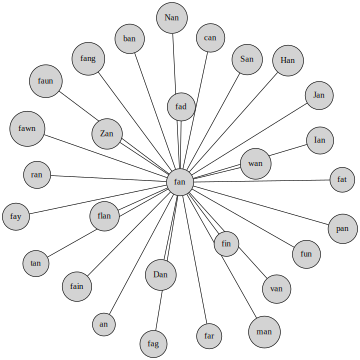

In [7]:
linksDF_filtered = linksDF.loc[(linksDF['from']=='fan') |(linksDF['to']=='fan')]
vz.graph2dot(linksDf    = linksDF_filtered,
             stdout     = 0,
             size       = 5,
             nodesAttrs = {"colorscheme":"accent4", "style":"filled"},
             graphAttrs = {"layout":"sfdp","outputorder":"edgesfirst"}
             )

### Executing `core` action to get the core decomposition of the graph <a class="anchor" id="6th-bullet"></a>

In [8]:
s.network.core(
    links    = {"name": "links"},
    nodes    = {"name": "cas_nodes"},
    outNodes = {"name": "NodeSetOut", "replace":True})

NOTE: The number of nodes in the input graph is 25435.
NOTE: The number of links in the input graph is 23420.
NOTE: Processing the core decomposition using 16 threads across 1 machines.
NOTE: Processing the core decomposition used 0.00 (cpu: 0.00) seconds.


[ProblemSummary]

 Problem Summary
 
             Name1           Label1       cValue1  nValue1
 0        numNodes  Number of Nodes         25435  25435.0
 1        numLinks  Number of Links         23420  23420.0
 2  graphDirection  Graph Direction    Undirected      NaN

[SolutionSummary]

 Solution Summary
 
          Name1           Label1             cValue1   nValue1
 0  problemType     Problem Type  Core Decomposition       NaN
 1       status  Solution Status                  OK       NaN
 2      cpuTime         CPU Time                0.00  0.000000
 3     realTime        Real Time                0.00  0.001709

[solutionStatus]

 'OK'

[solutionStatusCode]

 0

[OutputCasTables]

   casLib        Name Label   Rows  Columns                                casTable
 0  mycas  NodeSetOut        25435        2  CASTable('NodeSetOut', caslib='mycas')

+ Elapsed: 0.2s, user: 0.0225s, sys: 0.0106s, mem: 8.07mb

### Fetching the result from the CAS server <a class="anchor" id="7th-bullet"></a>

In [9]:
outDF = s.CASTable('NodeSetOut').to_frame()
outDF.core_out = outDF.core_out.astype(int)
outDF.head()

,node,core_out
0,monopoly,0
1,pronghorn,0
2,reactant,0
3,aggressor,0
4,musicology,0


<IPython.core.display.Javascript object>


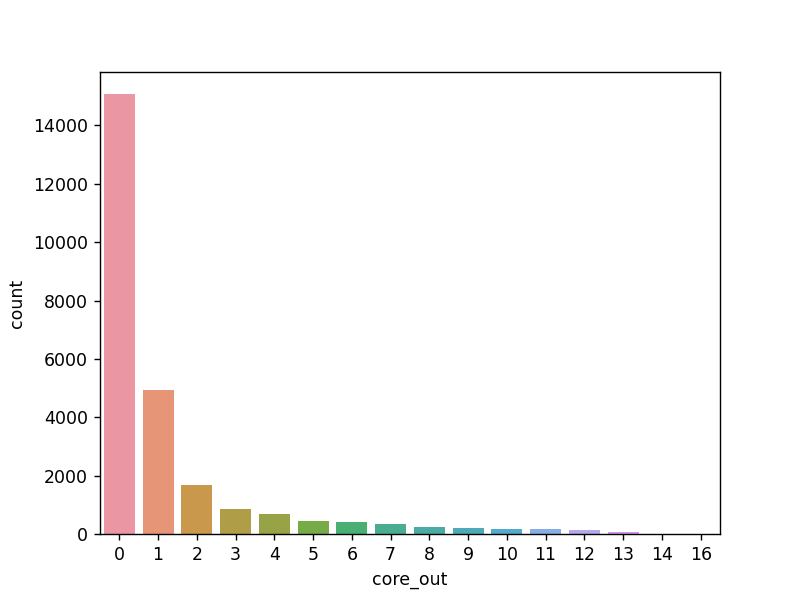

In [10]:
sns.countplot(x="core_out", data=outDF)
plt.show()

### Visualizing the graph of words with the highest core values <a class="anchor" id="8th-bullet"></a>

number of nodes in filtered graph: 17
number of links in filtered graph: 136


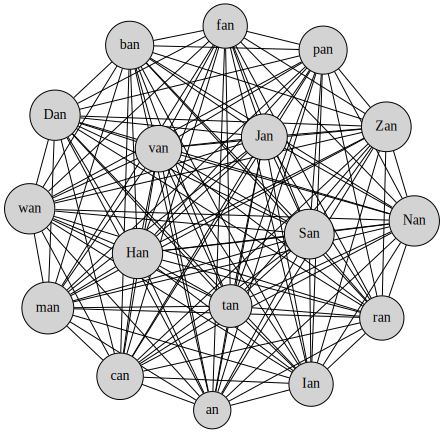

In [11]:
filtered_nodes = outDF.loc[outDF['core_out']==outDF['core_out'].max(),'node'].values
filtered_links = linksDF[(linksDF['from'].isin(filtered_nodes))&(linksDF['to'].isin(filtered_nodes))]
print(f'number of nodes in filtered graph: {len(filtered_nodes)}')
print(f'number of links in filtered graph: {filtered_links.shape[0]}')
vz.graph2dot(linksDf    = filtered_links,
             stdout     = 0,
             size       = 8,
             nodesAttrs = {"colorscheme":"accent4", "style":"filled"},
             graphAttrs = {"layout":"sfdp","outputorder":"edgesfirst"}
             )